In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Georgia
state_ab = "ga"

## Data
1. Download all the data in directory "ga_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
election2022 = "./{}{}_2022_gen_prec/{}_2022_gen_prec_no_splits/{}_2022_gen_prec_no_splits.shp".format(data_folder, state_ab, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2023/Congress-2023 shape.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2023/Senate-2023 shape file.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2023/House-2023 shape.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
    # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|█████████████████████████████████| 232717/232717 [01:22<00:00, 2834.55it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [23]:
maup.doctor(county_df)

100%|████████████████████████████████████████| 159/159 [00:00<00:00, 298.23it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

### vest 20 is not working, so we use vest 16 as our base data

In [27]:
vest16 = gpd.read_file(vest16_data)

In [28]:
vest16.columns

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS', 'geometry'],
      dtype='object')

In [29]:
start_col = 8
vest_base_data = vest16
year = '16'

In [30]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|████████████████████████████████████████| 159/159 [00:00<00:00, 297.56it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|█████████████████████████████████████████| 159/159 [00:02<00:00, 78.36it/s]


Identifying overlaps...


100%|███████████████████████████████████| 11436/11436 [00:05<00:00, 1939.26it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|█████████████| 73/73 [00:01<00:00, 42.17it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 2: 100%|█████████████| 50/50 [00:00<00:00, 90.84it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 3: 100%|████████████| 25/25 [00:00<00:00, 157.41it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 5: 100%|████████████| 12/12 [00:00<00:00, 136.15it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 6: 100%|████████████| 67/67 [00:00<00:00, 104.30it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 8: 100%|████████████| 18/18 [00:00<00:00, 152.56it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 11: 100%|████████████| 69/69 [00:00<00:00, 97.43it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 12: 100%|███████████| 42/42 [00:00<00:00, 150.33it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 13: 100%|████████████| 22/22 [00:00<00:00, 50.33it/s]
Gaps to

In [31]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [32]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 3116/3116 [00:01<00:00, 3084.15it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|██████████████████████████████████████| 2697/2697 [00:03<00:00, 811.61it/s]


In [33]:
maup.doctor(vest_base)

100%|██████████████████████████████████████| 2697/2697 [00:03<00:00, 882.61it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [35]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 2697/2697 [00:16<00:00, 160.41it/s]


In [36]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [37]:
election_df = gpd.GeoDataFrame(vest_base)

In [38]:
election_df.columns

Index(['CTYNAME', 'CTYNUMBER', 'CTYNUMBER2', 'CTYSOSID', 'DISTRICT', 'FIPS2',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRECINCT_I', 'PRECINCT_N', 'PSC16O',
       'PSC16R', 'USS16D', 'USS16O', 'USS16R', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [40]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [42]:
vest18 = gpd.read_file(vest18_data)

In [43]:
vest18.columns

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G18GOVRKEM', 'G18GOVDABR',
       'G18GOVLMET', 'G18LTGRDUN', 'G18LTGDAMI', 'G18SOSRRAF', 'G18SOSDBAR',
       'G18SOSLDUV', 'G18ATGRCAR', 'G18ATGDBAI', 'G18AGRRBLA', 'G18AGRDSWA',
       'G18INSRBEC', 'G18INSDLAW', 'G18INSLFOS', 'G18SPIRWOO', 'G18SPIDTHO',
       'G18LABRBUT', 'G18LABDKEA', 'G18PSCREAT', 'G18PSCDMIL', 'G18PSCLGRA',
       'G18PSCRPRI', 'G18PSCDRAN', 'G18PSCLTUR', 'R18SOSRRAF', 'R18SOSDBAR',
       'R18PSCREAT', 'R18PSCDMIL', 'geometry'],
      dtype='object')

In [44]:
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████████████████████████████████| 2658/2658 [00:03<00:00, 876.59it/s]


There are 347 overlaps.
There are 564 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 4653/4653 [00:01<00:00, 3710.44it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2697/2697 [00:17<00:00, 156.15it/s]


population agrees


In [45]:
elec22 = gpd.read_file(election2022)

In [46]:
print(list(elec22.columns))

['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'G22A01NO', 'G22A01YES', 'G22A02NO', 'G22A02YES', 'G22AGRDHEM', 'G22AGRLRAU', 'G22AGRRHAR', 'G22ATGDJOR', 'G22ATGLCOW', 'G22ATGRCAR', 'G22GOVDABR', 'G22GOVLHAZ', 'G22GOVRKEM', 'G22INSDROB', 'G22INSRKIN', 'G22LABDBOD', 'G22LABLAND', 'G22LABRTHO', 'G22LTGDBAI', 'G22LTGLGRA', 'G22LTGRJON', 'G22RFANO', 'G22RFAYES', 'G22RFBNO', 'G22RFBYES', 'G22SOSDNGU', 'G22SOSLMET', 'G22SOSRRAF', 'G22SUPDSEA', 'G22SUPRWOO', 'G22USSDWAR', 'G22USSLOLI', 'G22USSRWAL', 'GCON01DHER', 'GCON01RCAR', 'GCON02DBIS', 'GCON02RWES', 'GCON03DALM', 'GCON03RFER', 'GCON04DJOH', 'GCON04RCHA', 'GCON05DWIL', 'GCON05RZIM', 'GCON06DCHR', 'GCON06RMCC', 'GCON07DMCB', 'GCON07RGON', 'GCON08DBUT', 'GCON08RSCO', 'GCON09DFOR', 'GCON09RCLY', 'GCON10DJOH', 'GCON10RCOL', 'GCON11DDAZ', 'GCON11RLOU', 'GCON12DJOH', 'GCON12RALL', 'GCON13DSCO', 'GCON13RGON', 'GCON14DFLO', 'GCON14RGRE', 'GSL001RCAM', 'GSL002RTAR', 'GSL003RHOR', 'GSL004RCAR', 'GSL005RBAR', 'GSL006RRID', 'GSL007RRAL', 'GSL008DKRI'

In [47]:
cols_to_drop = ['G22RFANO', 'G22RFAYES', 'G22RFBNO', 'G22RFBYES', 'GCON01DHER', 'GCON01RCAR', 'GCON02DBIS', 'GCON02RWES', 'GCON03DALM', 'GCON03RFER', 'GCON04DJOH', 'GCON04RCHA', 'GCON05DWIL', 'GCON05RZIM', 'GCON06DCHR', 'GCON06RMCC', 'GCON07DMCB', 'GCON07RGON', 'GCON08DBUT', 'GCON08RSCO', 'GCON09DFOR', 'GCON09RCLY', 'GCON10DJOH', 'GCON10RCOL', 'GCON11DDAZ', 'GCON11RLOU', 'GCON12DJOH', 'GCON12RALL', 'GCON13DSCO', 'GCON13RGON', 'GCON14DFLO', 'GCON14RGRE', 'GSL001RCAM', 'GSL002RTAR', 'GSL003RHOR', 'GSL004RCAR', 'GSL005RBAR', 'GSL006RRID', 'GSL007RRAL', 'GSL008DKRI', 'GSL008RGUN', 'GSL009RWAD', 'GSL010RAND', 'GSL011DHOL', 'GSL011RJAS', 'GSL012RLUM', 'GSL013RDEM', 'GSL014RSCO', 'GSL015RGAM', 'GSL016RKEL', 'GSL017DMAR', 'GSL017RMOM', 'GSL018DRHU', 'GSL018RSMI', 'GSL019DCOY', 'GSL019RGUL', 'GSL020RBYR', 'GSL021RTHO', 'GSL022DHIL', 'GSL022RRID', 'GSL023RBAL', 'GSL024DWAL', 'GSL024RBAR', 'GSL025DMEY', 'GSL025RJON', 'GSL026DHEL', 'GSL026RMCD', 'GSL027RHAW', 'GSL028DWOO', 'GSL028RCOX', 'GSL029DPAN', 'GSL029RDUB', 'GSL030DFLO', 'GSL030RMCC', 'GSL031RDUN', 'GSL032RERW', 'GSL033RPOW', 'GSL034DCOK', 'GSL034RSEA', 'GSL035DCAM', 'GSL035RTRI', 'GSL036DRYN', 'GSL036REHR', 'GSL037DWIL', 'GSL037RRED', 'GSL038DWIL', 'GSL039DCUM', 'GSL039RANG', 'GSL040DSTO', 'GSL040RFON', 'GSL041DSMI', 'GSL041RROD', 'GSL042DANU', 'GSL043DADE', 'GSL043RTIL', 'GSL044DOYO', 'GSL044RPAR', 'GSL045DMCC', 'GSL045RCOO', 'GSL046DGAR', 'GSL046RCAR', 'GSL047RJON', 'GSL048DROB', 'GSL048RHIL', 'GSL049DGIL', 'GSL049RMAR', 'GSL050DAU', 'GSL050RRED', 'GSL051DPAN', 'GSL051RKOR', 'GSL052DROB', 'GSL052RAHR', 'GSL053DCOF', 'GSL053RSIL', 'GSL054DHOL', 'GSL054RBAI', 'GSL055DWIL', 'GSL055RLEN', 'GSL056DMAI', 'GSL057DEVA', 'GSL058DCAN', 'GSL059DOLA', 'GSL060DJON', 'GSL061DBRU', 'GSL062DMIL', 'GSL063DSCH', 'GSL064DEDW', 'GSL064RNEW', 'GSL065DTHO', 'GSL065RHOR', 'GSL066DALE', 'GSL067DGLA', 'GSL067RAMI', 'GSL068DNAG', 'GSL068RMAT', 'GSL069DBAZ', 'GSL070DAND', 'GSL070RSMI', 'GSL071DOKA', 'GSL071RCOL', 'GSL072RHUD', 'GSL073RBON', 'GSL074DHAR', 'GSL074RMAT', 'GSL075DGLA', 'GSL075RASH', 'GSL076DSCO', 'GSL077DBUR', 'GSL078DDOU', 'GSL079DNEA', 'GSL080DTRA', 'GSL080RAND', 'GSL081DHOL', 'GSL081RBEN', 'GSL082DOLI', 'GSL082RMIL', 'GSL083DLUP', 'GSL083RBER', 'GSL084DCRA', 'GSL085DDRE', 'GSL086DBAR', 'GSL086RKIN', 'GSL087DDAV', 'GSL088DMIT', 'GSL088RFRE', 'GSL089DEVA', 'GSL089RSHE', 'GSL090DDRA', 'GSL090RDIO', 'GSL091DMOO', 'GSL092DTAY', 'GSL093DCAR', 'GSL094DBEN', 'GSL095DKEN', 'GSL095RDAW', 'GSL096DMAR', 'GSL096RLOW', 'GSL097DROM', 'GSL097RCHA', 'GSL098DLIM', 'GSL099DDUG', 'GSL099RREE', 'GSL100DJAC', 'GSL100RCLA', 'GSL101DKEN', 'GSL101RPRO', 'GSL102DOKO', 'GSL102RHAR', 'GSL103DANA', 'GSL103RHON', 'GSL104DREI', 'GSL104REFS', 'GSL105DMUG', 'GSL105RDON', 'GSL106DHUT', 'GSL106RWRE', 'GSL107DPAR', 'GSL107RCAO', 'GSL108DCLA', 'GSL108RCRI', 'GSL109DMCC', 'GSL110DADE', 'GSL111DCOX', 'GSL111RMAR', 'GSL112DREE', 'GSL112RWIL', 'GSL113DHEN', 'GSL114DADA', 'GSL114RFLE', 'GSL115DLEW', 'GSL116DHOL', 'GSL116RBEN', 'GSL117DRUC', 'GSL117RDAN', 'GSL118DBEL', 'GSL118RCRO', 'GSL119RRAM', 'GSL120DJOH', 'GSL120RGAI', 'GSL121DAUE', 'GSL121RWIE', 'GSL122DFRY', 'GSL123RLEV', 'GSL124DHOW', 'GSL124RRHO', 'GSL125RFLE', 'GSL126DFRA', 'GSL126RHAR', 'GSL127RNEW', 'GSL128DJAC', 'GSL129DHOW', 'GSL130DGLA', 'GSL130RSWE', 'GSL131RLOT', 'GSL132DPRI', 'GSL133DWAL', 'GSL133RVAN', 'GSL134DDIC', 'GSL134RKNI', 'GSL135RCAM', 'GSL136RJEN', 'GSL137DBUC', 'GSL137RRIC', 'GSL138RSMI', 'GSL139RSMI', 'GSL140DREE', 'GSL141DHUG', 'GSL142DPAR', 'GSL143DBEV', 'GSL144DCON', 'GSL144RWAS', 'GSL145RDIC', 'GSL146DDRI', 'GSL146RBLA', 'GSL147DPHI', 'GSL147RBAL', 'GSL148RWIL', 'GSL149RMAT', 'GSL150DBEN', 'GSL151DBAR', 'GSL151RCHE', 'GSL152RYEA', 'GSL153DSAM', 'GSL153RTAY', 'GSL154DHAY', 'GSL154RGRE', 'GSL155RHAT', 'GSL156DKIT', 'GSL156RHAG', 'GSL157RWER', 'GSL158DSMI', 'GSL158RPAR', 'GSL159RBUR', 'GSL160RFRA', 'GSL161DBAR', 'GSL161RHIT', 'GSL162DGIL', 'GSL163DWES', 'GSL164DTHO', 'GSL164RSTE', 'GSL165DJAC', 'GSL166RPET', 'GSL167RDEL', 'GSL168DWIL', 'GSL169DBRO', 'GSL169RPIR', 'GSL170RHOU', 'GSL171RCAM', 'GSL172RWAT', 'GSL173DSR', 'GSL173RTAY', 'GSL174RCOR', 'GSL175RLAH', 'GSL176RBUR', 'GSL177DSHA', 'GSL178RMEE', 'GSL179RTOW', 'GSL180RSAI', 'GSU01DJON', 'GSU01RWAT', 'GSU02DMAL', 'GSU02RYOU', 'GSU03RHOD', 'GSU04RHIC', 'GSU05DRAH', 'GSU06DEST', 'GSU06RGLA', 'GSU07DISL', 'GSU07RMCK', 'GSU08RGOO', 'GSU09DMER', 'GSU10DJON', 'GSU11RBUR', 'GSU12DSIM', 'GSU13RSUM', 'GSU14DMCL', 'GSU14RHAU', 'GSU15DHAR', 'GSU16DDUB', 'GSU16RHAR', 'GSU17DMOR', 'GSU17RSTR', 'GSU18DBEN', 'GSU18RKEN', 'GSU19DMOO', 'GSU19RTIL', 'GSU20RWAL', 'GSU21RBEA', 'GSU22DJON', 'GSU22RDAN', 'GSU23RBUR', 'GSU24RAND', 'GSU25DROD', 'GSU25RWIL', 'GSU26DLUC', 'GSU27DBIN', 'GSU27RDOL', 'GSU28RBRA', 'GSU29DWRI', 'GSU29RROB', 'GSU30RDUG', 'GSU31RANA', 'GSU32DBEN', 'GSU32RKIR', 'GSU33DRHE', 'GSU34DSEA', 'GSU34RSMI', 'GSU35DJAM', 'GSU36DORR', 'GSU37DPAR', 'GSU37RSET', 'GSU38DTAT', 'GSU39DHAL', 'GSU40DHAR', 'GSU40RMCD', 'GSU41DJAC', 'GSU41RJON', 'GSU42DPAR', 'GSU43DAND', 'GSU43RWIL', 'GSU44DDAV', 'GSU45DJON', 'GSU45RDIX', 'GSU46DFER', 'GSU46RCOW', 'GSU47DSCO', 'GSU47RGIN', 'GSU48DUDD', 'GSU48RSTI', 'GSU49DCOO', 'GSU49RECH', 'GSU50DWIL', 'GSU50RHAT', 'GSU51RGOO', 'GSU52RHUF', 'GSU53RMOO', 'GSU54RPAY', 'GSU55DBUT', 'GSU56DTHO', 'GSU56RALB']

In [48]:
elec22 = elec22.drop(columns = cols_to_drop, axis = 1)

In [49]:
print(list(elec22.columns))

['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'G22A01NO', 'G22A01YES', 'G22A02NO', 'G22A02YES', 'G22AGRDHEM', 'G22AGRLRAU', 'G22AGRRHAR', 'G22ATGDJOR', 'G22ATGLCOW', 'G22ATGRCAR', 'G22GOVDABR', 'G22GOVLHAZ', 'G22GOVRKEM', 'G22INSDROB', 'G22INSRKIN', 'G22LABDBOD', 'G22LABLAND', 'G22LABRTHO', 'G22LTGDBAI', 'G22LTGLGRA', 'G22LTGRJON', 'G22SOSDNGU', 'G22SOSLMET', 'G22SOSRRAF', 'G22SUPDSEA', 'G22SUPRWOO', 'G22USSDWAR', 'G22USSLOLI', 'G22USSRWAL', 'geometry']


For the 2022 election data, running maup.doctor before repairing didn't work.  So we repair here first:

In [51]:
elec22 = elec22.to_crs(elec22.estimate_utm_crs())
elec22 = maup.smart_repair(elec22, snap_precision = 8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 4252/4252 [00:01<00:00, 2932.06it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to fill: 100%|█████████████████████████████| 76/76 [00:20<00:00,  3.65it/s]


In [52]:
maup.doctor(elec22)

100%|██████████████████████████████████████| 2732/2732 [00:03<00:00, 861.21it/s]


True

In [53]:
election_df = add_vest(elec22, election_df, '22', population_df, 8, snap_precision = 8)

100%|██████████████████████████████████████| 2697/2697 [00:16<00:00, 164.67it/s]


population agrees


##  Add the district data

In [55]:
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [56]:
cd.head()

,ID,AREA,DATA,DISTRICT,POPULATION,F18_POP,NH_WHT,NH_BLK,HISPANIC_O,NH_ASN,...,F_NH_2_RAC,IDEAL_VALU,F_18_AP_WH,F_18_AP_IN,F_18_AP_AS,F_18_AP_HW,F_18_AP_OT,F_18_2_RAC,DISTRICT_L,geometry
0,1,10127.426758,2,002,765137,587555,305611,375124,45499,10263,...,0.040245,765136.0,0.468327,0.015445,0.018934,0.002189,0.043899,0.038509,002|0%,"POLYGON ((153153.161 3611192.046, 153153.628 3..."
1,2,4251.204102,3,003,765136,586319,492494,173004,48285,15959,...,0.050984,765136.0,0.723775,0.020902,0.025469,0.001184,0.048032,0.049671,003|0%,"POLYGON ((124205.608 3603719.389, 124197.225 3..."
2,3,8162.467285,1,001,765137,589266,440636,210695,59328,16737,...,0.053195,765136.0,0.666193,0.020010,0.029893,0.002915,0.054580,0.051632,001|0%,"POLYGON ((364728.407 3537581.999, 364782.898 3..."
3,4,11088.923828,8,008,765136,585857,443123,227430,54850,11916,...,0.040346,765136.0,0.655996,0.016308,0.020273,0.001436,0.048297,0.039981,008|0%,"POLYGON ((216473.459 3677874.039, 216506.285 3..."
4,5,9829.969727,12,012,765136,588119,398843,276358,43065,14024,...,0.046987,765136.0,0.595143,0.016735,0.025544,0.002231,0.040080,0.043274,012|0%,"POLYGON ((348010.128 3761623.673, 348019.716 3..."


In [57]:
election_df = add_district(cd, "CD", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 14/14 [00:01<00:00, 13.66it/s]


In [58]:
send.head()

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,IDEAL_VALU,NAME,POPULATION,DEVIATION,...,F_NH18_OTH,F_NH18_2_R,F_AP_WHT,F_AP_BLK,F_AP_IND,F_AP_ASN,F_AP_HWN,F_AP_OTH,F_18_AP_BL,geometry
0,1,125.000107,38,038,1.0,None,191284.0,None,192309,1025.0,...,0.004970,0.025072,0.331857,0.618983,0.012090,0.029120,0.001149,0.062316,0.608769,"POLYGON ((164648.908 3712832.924, 164016.920 3..."
1,2,87.601807,35,035,1.0,None,191284.0,None,192472,1188.0,...,0.006852,0.031711,0.349334,0.564970,0.015909,0.056756,0.001408,0.087093,0.546652,"POLYGON ((175984.353 3736780.753, 175975.642 3..."
2,3,51.919930,39,039,1.0,None,191284.0,None,192047,763.0,...,0.005204,0.030724,0.347873,0.581238,0.013361,0.059225,0.001505,0.057767,0.554199,"POLYGON ((173690.145 3722417.648, 173690.833 3..."
3,4,78.536438,33,033,1.0,None,191284.0,None,192766,1482.0,...,0.012291,0.037483,0.474498,0.363840,0.023977,0.052810,0.001530,0.199963,0.352603,"POLYGON ((185261.830 3761143.374, 185113.194 3..."
4,5,94.699898,56,056,1.0,None,191284.0,None,191226,-58.0,...,0.006334,0.035148,0.841517,0.080821,0.018078,0.071465,0.001177,0.082149,0.075737,"POLYGON ((177327.580 3789581.903, 177364.740 3..."


In [59]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 28.85it/s]


In [60]:
hdist.head()

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,DEVIATION,F_DEVIATIO,...,F_AP_ASN,F_AP_HWN,F_AP_OTH,F_18_AP_BL,F_PEOPLE_I,F_NH18_2_R,F_NH_2_RAC,IDEAL_VALU,DISTRICT_L,geometry
0,1,2621.328125,154,154,1.0,None,None,59994,483.0,0.008116,...,0.006951,0.001300,0.017752,0.548178,0.041071,0.017008,0.026463,59511.0,154|0.81%,"POLYGON ((129929.394 3404007.167, 129928.244 3..."
1,2,642.327576,173,173,1.0,None,None,59743,232.0,0.003898,...,0.011215,0.000603,0.060375,0.362713,0.010160,0.023050,0.035856,59511.0,173|0.39%,"POLYGON ((237089.356 3394956.113, 237086.578 3..."
2,3,1414.718262,171,171,1.0,None,None,59237,-274.0,-0.004604,...,0.008137,0.001080,0.049597,0.395962,0.042946,0.019470,0.029150,59511.0,171|-0.46%,"POLYGON ((202639.649 3442420.531, 202628.041 3..."
3,4,27.224514,140,140,1.0,None,None,59294,-217.0,-0.003646,...,0.019749,0.004857,0.071542,0.576344,0.045839,0.034338,0.057959,59511.0,140|-0.36%,"POLYGON ((127565.059 3588798.568, 127444.194 3..."
4,5,547.062561,138,138,1.0,None,None,58912,-599.0,-0.010065,...,0.031929,0.002139,0.035205,0.193153,0.021914,0.029748,0.048617,59511.0,138|-1.01%,"POLYGON ((115965.025 3677541.788, 115974.617 3..."


In [61]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|█████████████████████████████████████████| 180/180 [00:02<00:00, 63.76it/s]


In [62]:
maup.doctor(election_df)

100%|██████████████████████████████████████| 2697/2697 [00:03<00:00, 861.49it/s]


True

### Put the base precinct year after the precinct information column

In [64]:
base_columns = {}
if 'CTYSOSID' + year not in election_df.columns:
    base_columns = {
        'DISTRICT':'DISTRICT'+year,
        'CTYSOSID':'CTYSOSID'+year,
        'PRECINCT_I':'PRECINCT_I'+year,
        'PRECINCT_N':'PRECINCT_N'+year,
        'CTYNAME':'CTYNAME'+year,
        'CTYNUMBER':'CTYNUMBER'+year,
        'CTYNUMBER2':'CTYNUMBER2'+year,
        'FIPS2':'FIPS2'+year,
    }
election_df.rename(columns=base_columns, inplace = True)

In [65]:
# reorder the columns
fixed_columns = [
    'DISTRICT'+year,
    'CTYSOSID'+year,
    'PRECINCT_I'+year,
    'PRECINCT_N'+year,
    'CTYNAME'+year,
    'CTYNUMBER'+year,
    'CTYNUMBER2'+year,
    'FIPS2'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [66]:
import os

# store the result in directory "ga"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

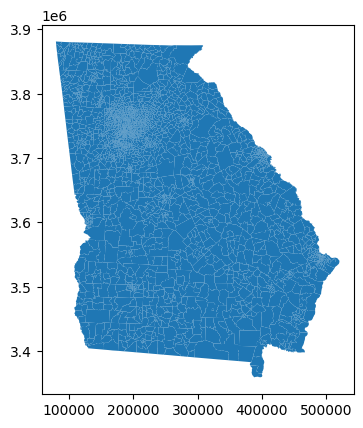

In [67]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()